In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import illustris_python as il
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
basePath = 'data'

In [26]:
fields = ['SubhaloFlag', 'SubhaloMass','SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 
          'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions']
subhalos = il.groupcat.loadSubhalos(basePath,33,fields=fields)

In [27]:
subhalos

{'count': 5621338,
 'SubhaloFlag': array([ True,  True,  True, ...,  True,  True,  True]),
 'SubhaloMass': array([2.5082502e+03, 6.9895546e+01, 1.7944519e+01, ..., 1.4156080e-02,
        1.2133783e-02, 1.4661655e-02], dtype=float32),
 'SubhaloMassType': array([[2.5807529e+02, 2.1866094e+03, 0.0000000e+00, 0.0000000e+00,
         6.3306679e+01, 2.5904831e-01],
        [8.9561052e+00, 5.6678417e+01, 0.0000000e+00, 0.0000000e+00,
         4.2417607e+00, 1.9262403e-02],
        [1.8322987e-02, 1.3868914e+01, 0.0000000e+00, 0.0000000e+00,
         4.0240345e+00, 3.3247355e-02],
        ...,
        [0.0000000e+00, 1.4156080e-02, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.2133783e-02, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.4661655e-02, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32),
 'SubhaloParent': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),


In [28]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [29]:
def impose_cut(subhalos, boolean_array):
    for key in subhalos.keys():
        if key != 'count':
            subhalos[key] = subhalos[key][boolean_array]
        else:
            subhalos[key] = sum(boolean_array)
    return subhalos

In [30]:
# subhalos = impose_cut(subhalos, subhalos['SubhaloMass']*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloMassType'][:,4]*1e10 >=1e9) # subhalo mass > 1e9 Msun
subhalos = impose_cut(subhalos, subhalos['SubhaloFlag'] > 0) # is actually a subhalo
subhalos = impose_cut(subhalos, subhalos['SubhaloLenType'][:,4] > 100) # more than 50 star particles

In [31]:
subhalos['SubhaloPos'].shape

(9826, 3)

In [32]:
for i in range(3):
    print(min(subhalos['SubhaloPos'][:,i]), max(subhalos['SubhaloPos'][:,i]))
    print(sum(subhalos['SubhaloPos'][:,i] < 5000))

0.47776374 74997.38
745
2.6708074 74999.85
689
18.934818 74996.07
680


In [33]:
limit = 40000
for i in range(3):
    subhalos = impose_cut(subhalos, subhalos['SubhaloPos'][:,i] < limit) # more than 50 star particles

In [34]:
subhalos['count']

1768

In [35]:
distance_matrix = euclidean_distances(subhalos['SubhaloPos'],subhalos['SubhaloPos']) # supposedly takes ~20 sec

In [36]:
distance_matrix.shape

(1768, 1768)

(array([ 79044., 276278., 507502., 660948., 709084., 532996., 267556.,
         79046.,  12454.,    916.]),
 array([    0.        ,  6300.27978516, 12600.55957031, 18900.83984375,
        25201.11914062, 31501.3984375 , 37801.6796875 , 44101.95703125,
        50402.23828125, 56702.515625  , 63002.796875  ]),
 <BarContainer object of 10 artists>)

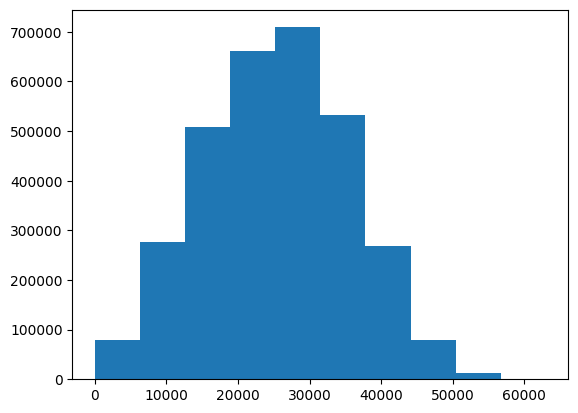

In [37]:
plt.hist((distance_matrix).flatten())

In [38]:
def normalize(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [39]:
distance_matrix = normalize(distance_matrix)

In [40]:
num_galaxies = subhalos['count']
edge_list = []
for i in range(num_galaxies):
    for j in range(i):
        edge_list.append((i, j, distance_matrix[i][j]))
        edge_list.append((j, i, distance_matrix[i][j])) # for directed graph hack

In [41]:
edge_list[:10]

[(1, 0, 0.0046331864),
 (0, 1, 0.0046331864),
 (2, 0, 0.0058874497),
 (0, 2, 0.0058874497),
 (2, 1, 0.007188592),
 (1, 2, 0.007188592),
 (3, 0, 0.0016176748),
 (0, 3, 0.0016176748),
 (3, 1, 0.004462028),
 (1, 3, 0.004462028)]

(array([ 79044., 276278., 507502., 660948., 709084., 532996., 267556.,
         79046.,  12454.,    916.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

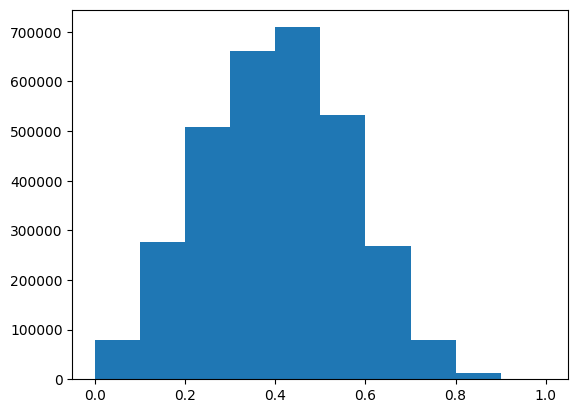

In [42]:
plt.hist((distance_matrix).flatten())

In [43]:
np.savetxt('tng_edgelist_small_both_ways_z2.txt', edge_list, fmt='%d')

In [44]:
nodes, *emb = np.loadtxt("struc2vec/emb/tng_small_both_ways_z2.emb", skiprows=1).T

emb = np.array(emb)
nodes = np.array(nodes, dtype=np.int32)
emb = emb[:,np.argsort(nodes)] # put these in the same order as the original nodes

In [45]:
emb.shape

(50, 1768)

In [46]:
pca = PCA(n_components=3)
pca.fit(emb)
print(pca.explained_variance_ratio_)

[0.40704305 0.01615592 0.01559672]


In [47]:
components = MinMaxScaler().fit_transform(pca.components_.T).T

(array([  2.,  18.,   4.,  26., 159., 470., 616., 361.,  99.,  13.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

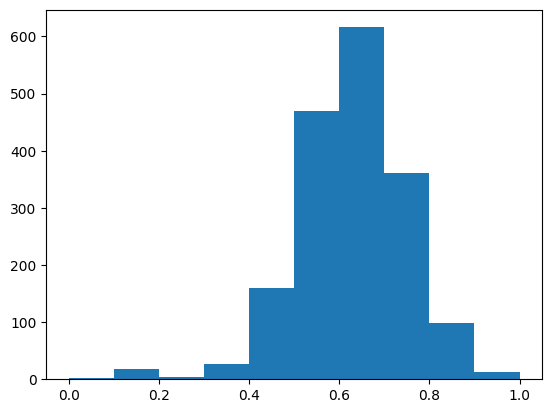

In [48]:
plt.hist(components[0])

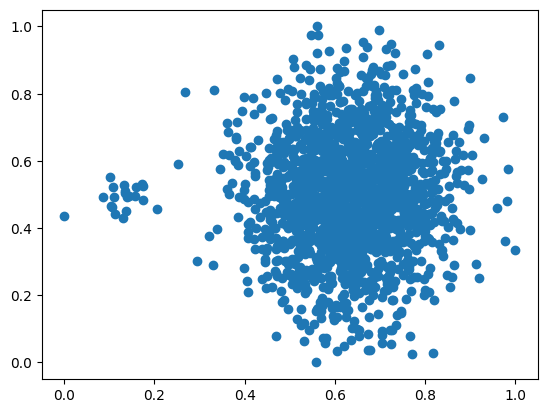

In [49]:
plt.plot(*components[[0,1]], 'o')

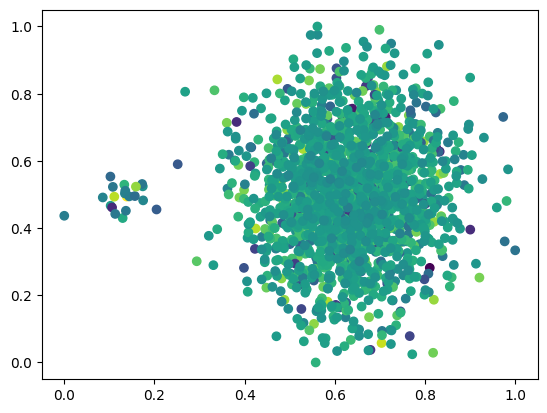

In [50]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMass']))

In [51]:
subhalos['SubhaloLenType'][:,1]

array([1679303,   42344,   27267, ...,   12248,   11660,   10965],
      dtype=int32)

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_67129/465684355.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]))


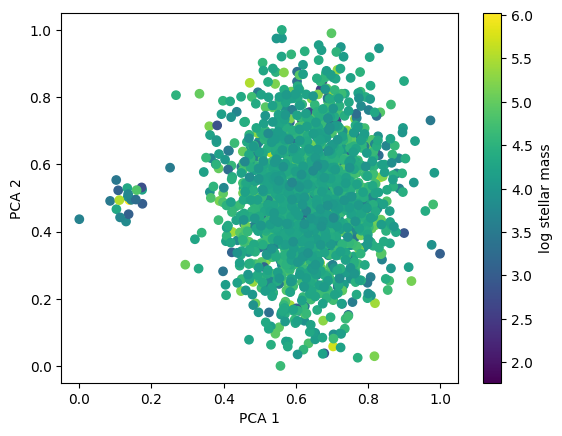

In [52]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloLenType'][:,0]))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

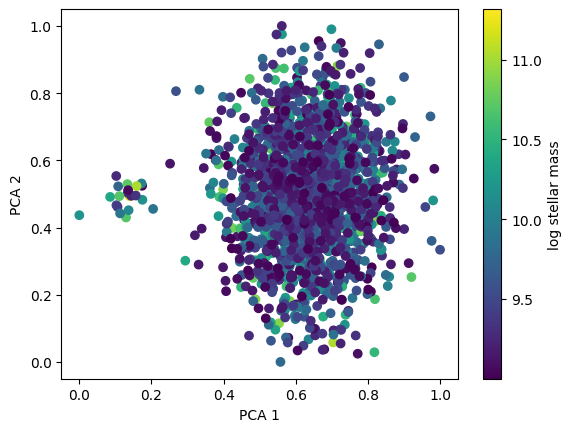

In [53]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloMassType'][:,4] * 1e10))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log stellar mass")

In [54]:
subhalos.keys()

dict_keys(['count', 'SubhaloFlag', 'SubhaloMass', 'SubhaloMassType', 'SubhaloParent', 'SubhaloPos', 'SubhaloLenType', 'SubhaloStarMetallicity', 'SubhaloSFR', 'SubhaloGasMetallicity', 'SubhaloGasMetalFractions'])

In [55]:
subhalos['SubhaloStarMetallicity']

array([0.02957279, 0.03196906, 0.00775352, ..., 0.00882796, 0.00957345,
       0.00912453], dtype=float32)

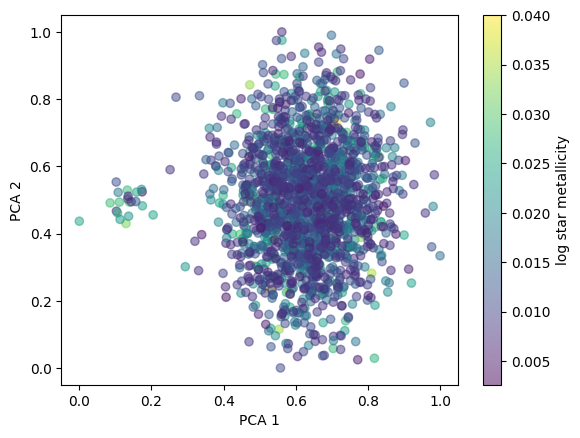

In [56]:
plt.scatter(*components[[0,1]], c = subhalos['SubhaloStarMetallicity'], alpha=0.5, vmax=0.04)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log star metallicity")

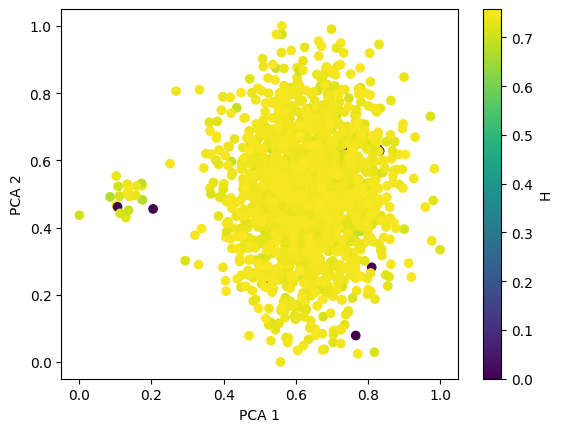

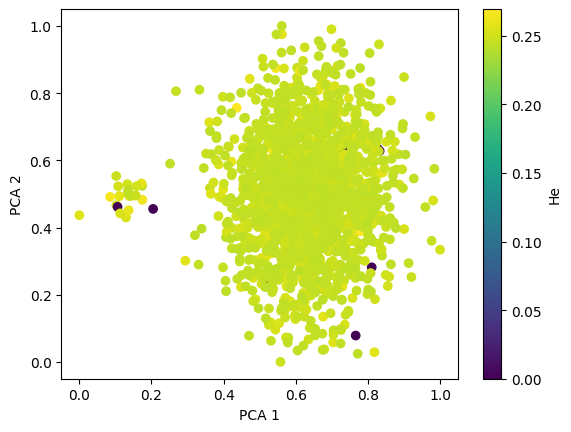

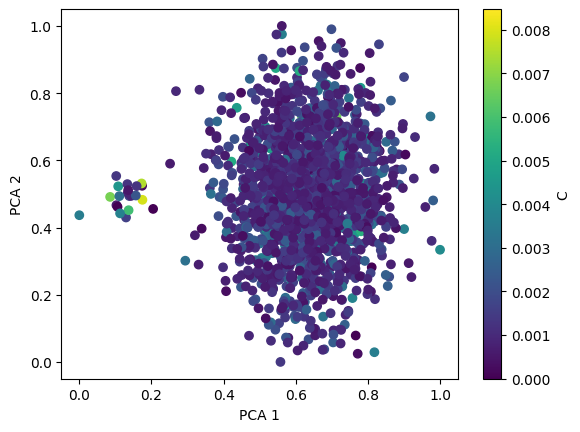

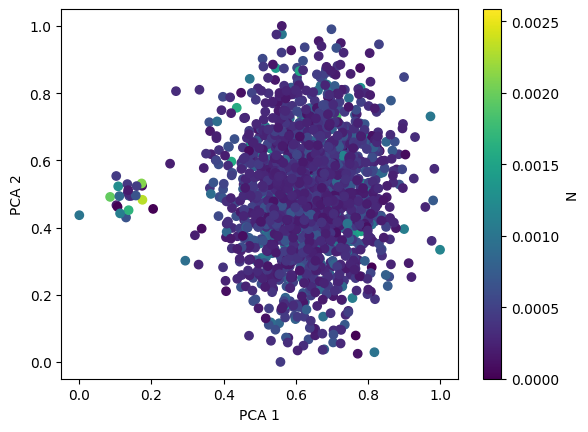

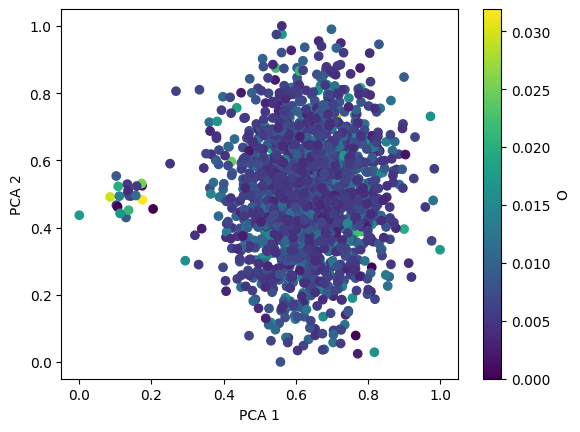

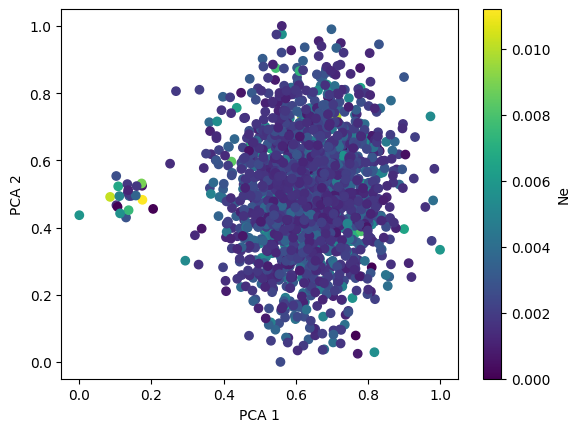

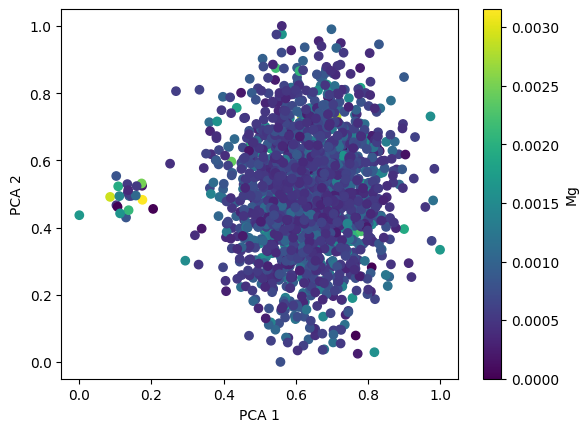

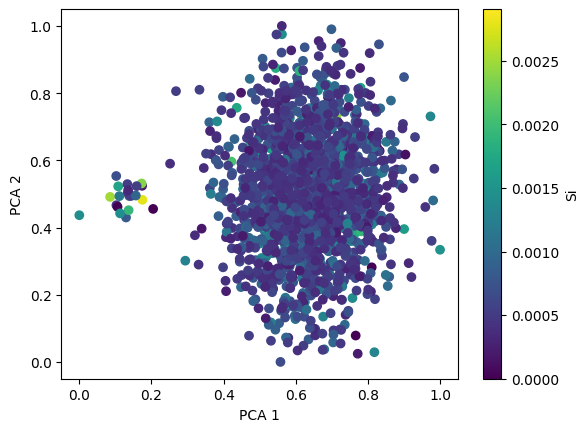

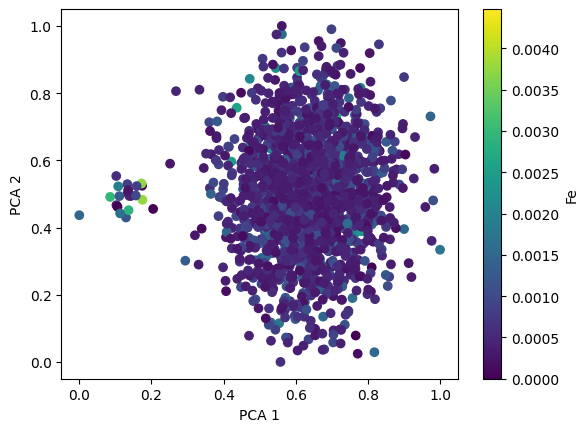

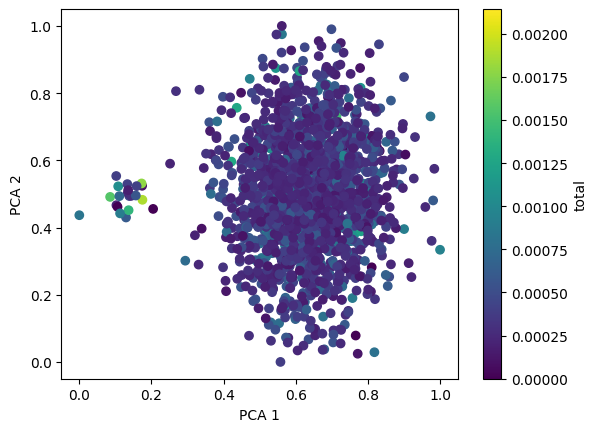

In [57]:
gases = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe', 'total']
for i in range(10):
    fig, ax = plt.subplots()
    s = ax.scatter(*components[[0,1]], c = subhalos['SubhaloGasMetalFractions'][:,i])
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    cbar = fig.colorbar(s, label=gases[i])
    plt.show()

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_67129/3922342893.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*pca.components_[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']), alpha=0.5)


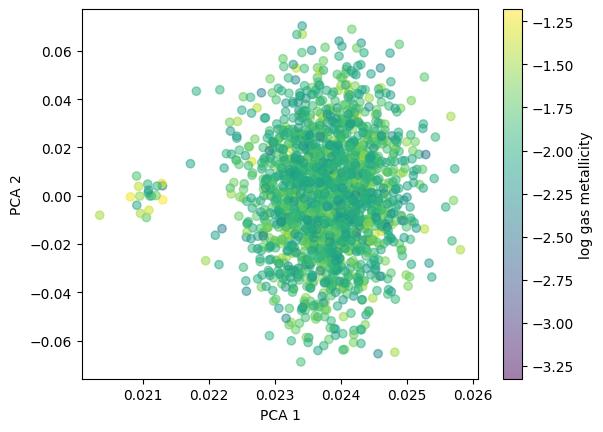

In [58]:
plt.scatter(*pca.components_[[0,1]], c = np.log10(subhalos['SubhaloGasMetallicity']), alpha=0.5)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log gas metallicity")

/var/folders/0r/_1bnthz146q2xj0c42f4nl_80000gq/T/ipykernel_67129/3560304120.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']))


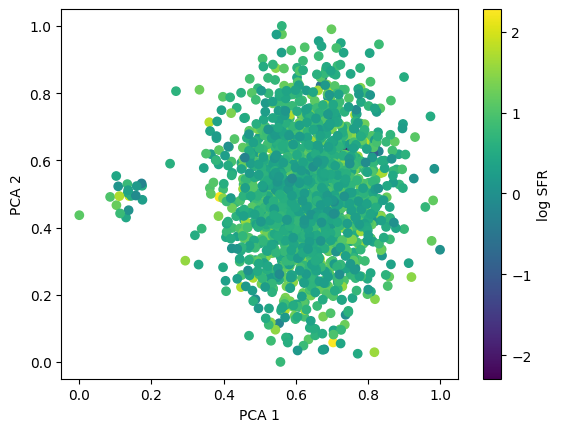

In [59]:
plt.scatter(*components[[0,1]], c = np.log10(subhalos['SubhaloSFR']))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="log SFR")

In [60]:
G = nx.Graph()
G.add_nodes_from(np.arange(subhalos['count']))

In [61]:
# ebunch = [(i[0], i[1], {'weight':i[2]}) for i in edge_list[::2]]
ebunch = [(i[0], i[1], i[2]) for i in edge_list[::2]]

In [62]:
G.add_weighted_edges_from(ebunch)

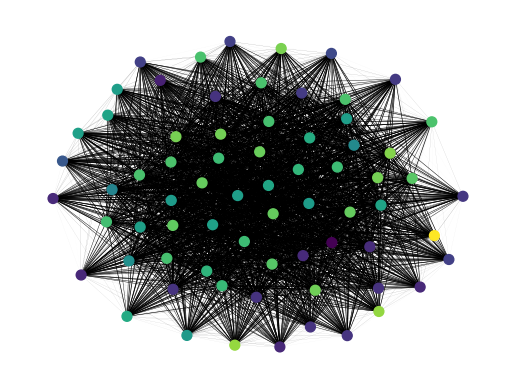

In [63]:
fig, ax = plt.subplots()
num_nodes = 70
subgraph = G.subgraph(np.arange(num_nodes))
nx.draw(subgraph, node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = components[0][:num_nodes])

In [64]:
cmap = mpl.colormaps['Spectral']

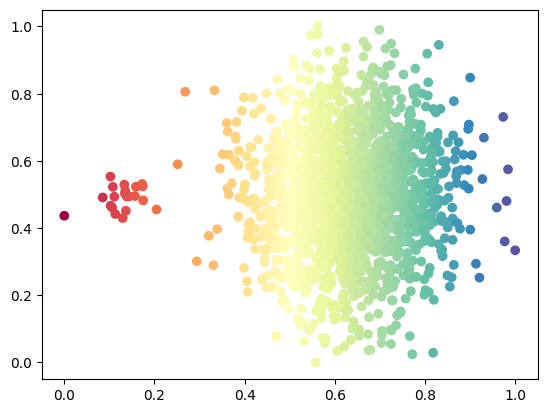

In [65]:
f = plt.scatter(components[0], components[1], c =components[0], cmap=cmap)

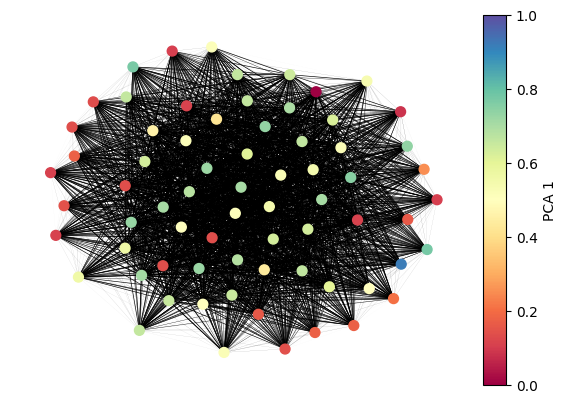

In [66]:
fig,ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
nx.draw(subgraph, pos = nx.spring_layout(subgraph), node_size=50, ax = ax, width = list(nx.get_edge_attributes(subgraph, "weight").values()), node_color = cmap(components[0][:num_nodes]))
cbar = plt.colorbar(f, cax=cax)
cbar.set_label("PCA 1")
plt.show()

In [472]:
list(nx.get_edge_attributes(subgraph, "weight").values())

[0.006940729,
 0.001271939,
 0.013901103,
 0.004911695,
 0.012705846,
 0.0029168064,
 0.015910426,
 0.0017758264,
 0.0077905916,
 0.014365947,
 0.01759326,
 0.009097281,
 0.012375661,
 0.004266901,
 0.018343415,
 0.009963802,
 0.017416997,
 0.010115551,
 0.004142944,
 0.0077868975,
 0.23605096,
 0.23399763,
 0.21739829,
 0.22480859,
 0.21886213,
 0.216991,
 0.24374555,
 0.24023569,
 0.25043368,
 0.22507863,
 0.23528731,
 0.24184245,
 0.23787494,
 0.21572493,
 0.23239912,
 0.23401758,
 0.24621455,
 0.2346173,
 0.24549063,
 0.24124134,
 0.2373302,
 0.23634708,
 0.2504729,
 0.24451056,
 0.22908151,
 0.21841513,
 0.23718517,
 0.25075758,
 0.2326855,
 0.006265746,
 0.013722602,
 0.0026141105,
 0.013778109,
 0.009570136,
 0.010986077,
 0.0062295264,
 0.013401577,
 0.010365479,
 0.013104689,
 0.010571859,
 0.01614962,
 0.0031936294,
 0.018582325,
 0.0038045624,
 0.011901451,
 0.011439154,
 0.010546837,
 0.0091662565,
 0.23787835,
 0.23597328,
 0.21944292,
 0.22674206,
 0.22093023,
 0.21856524

In [352]:
# filename = "snap_099.0.hdf5"
# with h5py.File(filename, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     a_group_key = list(f.keys())[0]
#     for key in f.keys():
#         print(key)
#         print(list(f[key]))
    
#     print(type(f[a_group_key])) 
